# Different kinds of inference in PyMC3

In [1]:
%pylab inline
import matplotlib.pylab as plt
from mpl_toolkits import mplot3d
import numpy as np
import pymc3 as pm

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


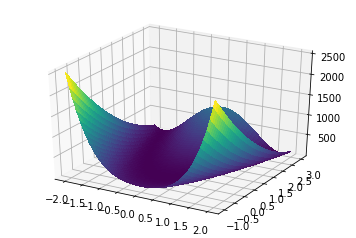

In [2]:
def cust_logp(z):
    return -(1. - z[0])**2 - 100. * (z[1] - z[0]**2)**2


grid = np.mgrid[-2:2:100j, -1:3:100j]
Z = -np.asarray([cust_logp(g) for g in grid.reshape(2, -1).T])
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(grid[0], grid[1], Z.reshape(100, 100), cmap='viridis',
                       linewidth=0, antialiased=False)

In [3]:
with pm.Model() as m:
    pm.DensityDist('pot1', logp=cust_logp, shape=(2,))
    tr1 = pm.sample(500, step=pm.NUTS())
    tr2 = pm.sample(500, step=pm.Metropolis())
    tr3 = pm.fit(n=40000, method='fullrank_advi').sample(500)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [pot1]
100%|██████████| 1000/1000 [00:04<00:00, 241.43it/s]
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6651855821632737, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [pot1]
100%|██████████| 1000/1000 [00:00<00:00, 7187.37it/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Average Loss = 2.6059: 100%|██████████| 40000/40000 [00:25

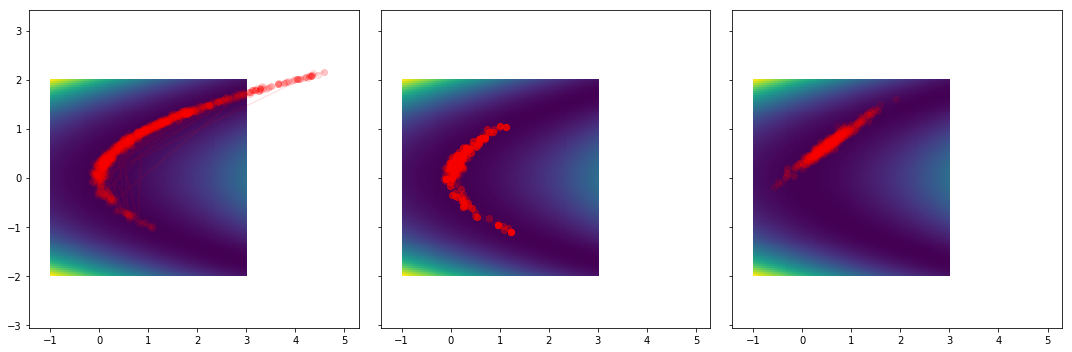

In [4]:
import matplotlib.pylab as plt
_, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax[0].imshow(Z.reshape(100, 100), extent=[-1, 3, -2, 2, ])
ax[0].plot(tr1['pot1'][:, 1], tr1['pot1'][:, 0], 'ro-', alpha=.1)
ax[1].imshow(Z.reshape(100, 100), extent=[-1, 3, -2, 2, ])
ax[1].plot(tr2['pot1'][:, 1], tr2['pot1'][:, 0], 'ro-', alpha=.1)
ax[2].imshow(Z.reshape(100, 100), extent=[-1, 3, -2, 2, ])
ax[2].plot(tr3['pot1'][:, 1], tr3['pot1'][:, 0], 'ro', alpha=.1)
plt.tight_layout()

In [5]:
with pm.Model():
    pm.DensityDist('pot1', logp=cust_logp, shape=(2,))
    minimal=pm.find_MAP()
minimal

logp = -0.00017766, ||grad|| = 0.58277: 100%|██████████| 26/26 [00:00<00:00, 186.71it/s]  


{'pot1': array([0.99999971, 0.9999994 ])}

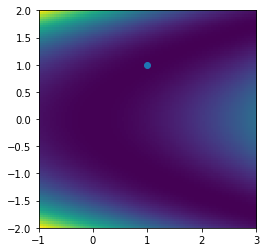

In [6]:
plt.imshow(Z.reshape(100, 100), extent=[-1, 3, -2, 2, ])
plt.plot(minimal['pot1'][0], minimal['pot1'][1], 'o');

# Display trace

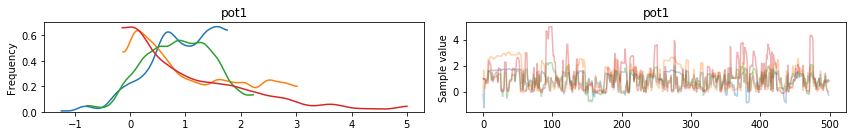

In [6]:
pm.traceplot(tr1);

In [7]:
pm.summary(tr1)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
pot1__0,0.875642,0.604070,0.042255,-0.240570,1.940029,102.816133,0.999002
pot1__1,1.133247,1.039879,0.075196,-0.130204,2.939930,100.530421,0.999182


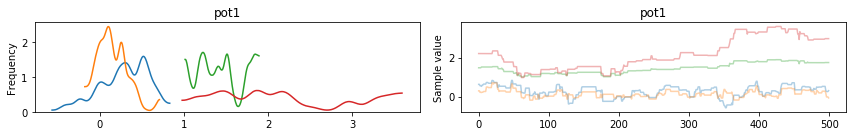

In [8]:
pm.traceplot(tr2);

In [9]:
pm.summary(tr2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
pot1__0,0.864903,0.645662,0.064076,-0.124408,1.890272,1.157576,3.151405
pot1__1,1.157248,1.157472,0.115424,-0.117010,3.455894,1.244502,2.704039


# Basic HMC

In [7]:
with m:
    hmc = pm.HamiltonianMC()


def showstep(hmc, q0, model, epsilon=.025, n_steps=20):
    size = model.ndim
    hmc.integrator._logp_dlogp_func.set_extra_values({})

    post_evo = np.zeros((n_steps + 1, size))
    post_evo[0, :] = q0

    p0 = hmc.potential.random()
    start = hmc.integrator.compute_state(q0, p0)

    state = start
    for i in range(n_steps):
        state = hmc.integrator.step(epsilon, state)
        post_evo[i + 1, :] = state.q
    energy_change = start.energy - state.energy
    return energy_change, state, start, post_evo


q0 = pm.floatX(np.asarray([-1, 2]))
energy_change, state, start, post_evo = showstep(
    hmc, q0, m, epsilon=.025, n_steps=20)
print(start)
print(state)

State(q=array([-1.,  2.]), p=array([-1.04800753, -0.75557838]), v=array([-1.04800753, -0.75557838]), q_grad=array([-396., -200.]), energy=104.83460923564935)
State(q=array([ 0.56922573, -0.40130994]), p=array([-8.91279614,  3.30315849]), v=array([-8.91279614,  3.30315849]), q_grad=array([-164.28856407,  145.06557291]), energy=97.97001314082308)


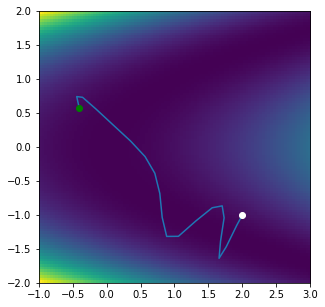

In [8]:
metrop_select = pm.step_methods.arraystep.metrop_select


def plotpost(energy_change, state, start, post_evo):
    q, accept = metrop_select(energy_change, state.q, start.q)
    colorall = ['r', 'g']
    _, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(Z.reshape(100, 100), extent=[-1, 3, -2, 2, ])
    ax.plot(post_evo[:, 1], post_evo[:, 0]);
    ax.plot(post_evo[0, 1], post_evo[0, 0], 'wo')
    ax.plot(post_evo[-1, 1], post_evo[-1, 0], 'o', color=colorall[accept])
    return q


q1 = plotpost(energy_change, state, start, post_evo);

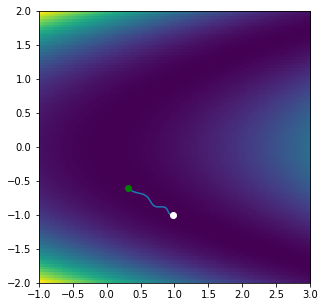

In [16]:
q0 = q1
energy_change, state, start, post_evo = showstep(
    hmc, q0, m, epsilon=.025, n_steps=20)
q1 = plotpost(energy_change, state, start, post_evo);

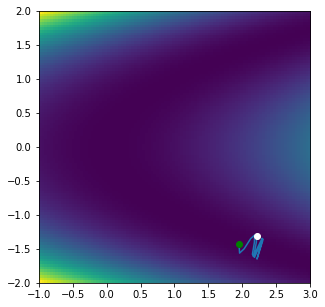

In [12]:
q0 = q1
energy_change, state, start, post_evo = showstep(
    hmc, q0, m, epsilon=.025, n_steps=20)
q1 = plotpost(energy_change, state, start, post_evo);

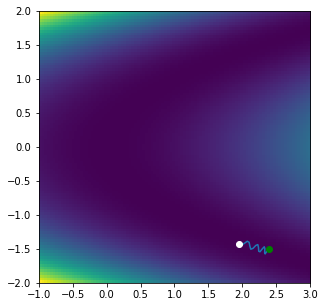

In [13]:
q0 = q1
energy_change, state, start, post_evo = showstep(
    hmc, q0, m, epsilon=.025, n_steps=20)
q1 = plotpost(energy_change, state, start, post_evo);

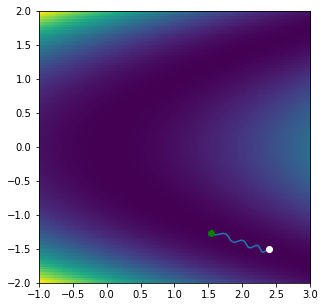

In [14]:
q0 = q1
energy_change, state, start, post_evo = showstep(
    hmc, q0, m, epsilon=.025, n_steps=20)
q1 = plotpost(energy_change, state, start, post_evo);

In [15]:
with m:
    hmc = pm.HamiltonianMC(path_length=.5, step_scale=.025)

In [16]:
hmc._hamiltonian_step(start, q0, hmc.step_size)

HMCStepData(end=State(q=array([-1.3946998 ,  1.89868382]), p=array([-0.55285036, -2.20660068]), v=array([-0.55285036, -2.20660068]), q_grad=array([30.73288696,  9.30074249]), energy=8.538211699427542), accept_stat=1, divergence_info=None, stats={'path_length': 0.3207799164949045, 'n_steps': 15, 'accept': 1, 'energy_error': 0.1929319568053316, 'accepted': True, 'energy': 8.538211699427542})

Sequential sampling (1 chains in 1 job)
HamiltonianMC: [pot1]
100%|██████████| 500/500 [00:00<00:00, 771.21it/s]
The acceptance probability does not match the target. It is 0.9836370555722631, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


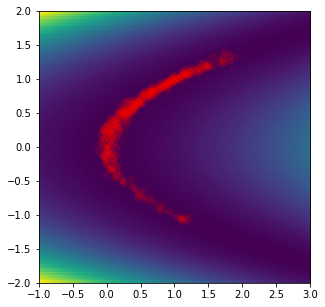

In [18]:
with m:
    trh = pm.sample(500, step=hmc, tune=0, chains=1,
                    start=dict(pot1=np.asarray([-1, 2])))

_, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(Z.reshape(100, 100), extent=[-1, 3, -2, 2, ])
ax.plot(trh['pot1'][:, 1], trh['pot1'][:, 0], 'ro-', alpha=.1);

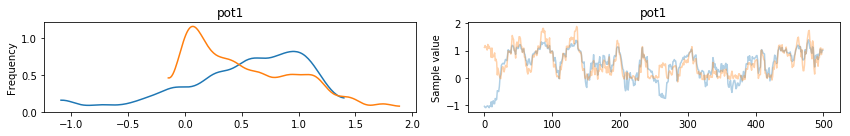

In [19]:
pm.traceplot(trh);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [pot1]
100%|██████████| 2500/2500 [00:09<00:00, 260.55it/s]
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6759779393703929, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


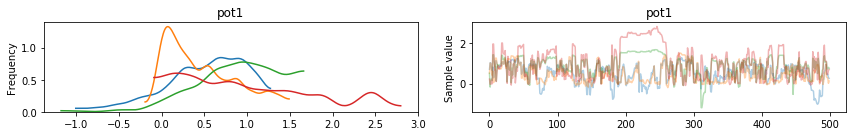

In [10]:
with m:
    tr4 = pm.sample(tune=2000, nuts_args=dict(target_accept=.95))

pm.traceplot(tr4);

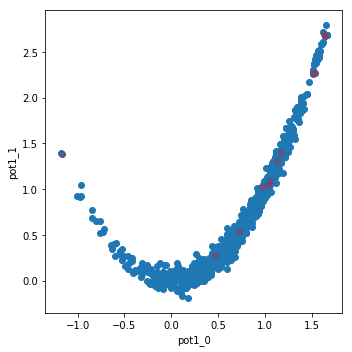

In [11]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))
pm.pairplot(tr4, divergences=True, ax=ax, 
            kwargs_divergence=dict(alpha=.25, color='r'));

More information see
http://docs.pymc.io/notebooks/Diagnosing_biased_Inference_with_Divergences.html

In [12]:
pm.summary(tr4)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
pot1__0,0.692040,0.515550,0.042692,-0.234627,1.661046,9.892394,1.142277
pot1__1,0.743591,0.680805,0.057307,-0.113833,2.364682,6.450779,1.171204


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [pot1]
100%|██████████| 4000/4000 [00:09<00:00, 405.44it/s]
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5278308157918877, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8945592791811225, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


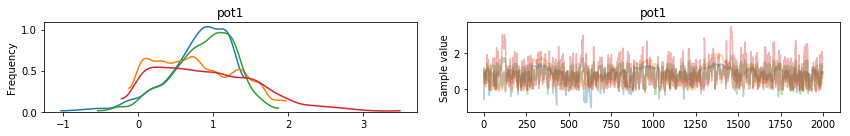

In [19]:
with pm.Model() as m2:
    x = pm.Normal('pot1', 1., 1., shape=2,)
    pm.DensityDist('pot_', logp=cust_logp, observed=dict(z=x))
    tr5 = pm.sample(2000, tune=2000, nuts_args=dict(target_accept=.95))

pm.traceplot(tr5);

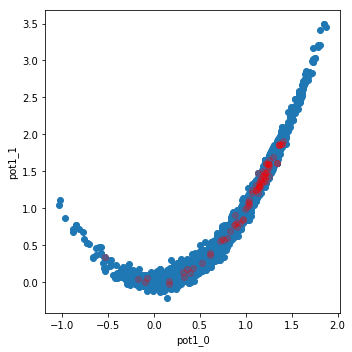

In [20]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))
pm.pairplot(tr5, divergences=True, ax=ax,
           kwargs_divergence=dict(alpha=.25, color='r'));

In [21]:
pm.summary(tr5)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
pot1__0,0.822935,0.423625,0.02512,-0.029354,1.585354,115.830013,1.015063
pot1__1,0.858183,0.613882,0.03721,-0.076241,1.907674,113.388060,1.018250


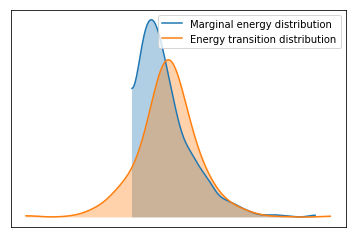

In [16]:
pm.energyplot(tr4);

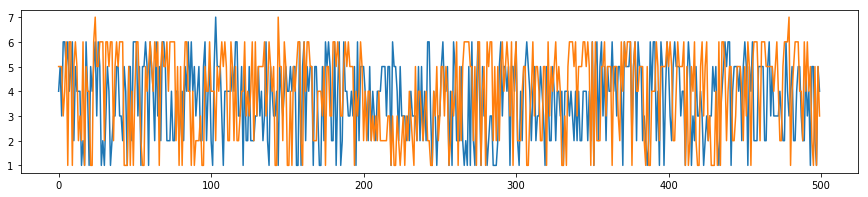

In [18]:
treedp = tr4.get_sampler_stats('depth', combine=False)
_, ax1 = plt.subplots(1, 1, figsize=(15, 3))
for treedp_ in treedp:
    ax1.plot(treedp_)